In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import IPython
IPython.display.Audio("ibeep.mp3",autoplay=True)

In [3]:
import numpy as np
np.set_printoptions(linewidth=np.inf)
import sympy as sp
import scipy as sc
from colorednoise import powerlaw_psd_gaussian as cn
from scipy import integrate,signal,stats,io
from sklearn.linear_model import Lasso,ridge_regression
from sklearn.utils.extmath import weighted_mode

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

import pysindy as ps

from tqdm import tqdm,tnrange

import copy

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

C:\Users\rautj\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [4]:
from sindy_functions import *
from systems import *

In [5]:
#example problem

def exsys(tlim,dt=0.01,ff=5,m=1,k1=0,k2=1000,c=1):
    
    """
    Bearing outer race fault - like signal generator
    
    Inputs: (tlim, dt=0.01, ff=5, m=1, k=1000, c=10, iscale=1)
    Retruns: (time stamps, actual system state, system & signal properties)
    """
    
    def F(t):
        if abs(t%ff)<=(1.05*0.01):
            r=1000
        else:
            r=-m*10
        return r
    
    mkc=tuple([m,k1,k2,c])
    
    def smd(x,t,m,k1,k2,c):
        dx=[x[1]-x[0],
            F(t)/m-(k1*(x[0]**1)+k2*(x[0]**3)+c*(x[1]))/m]
        return dx

    tstamps=np.arange(0,tlim,dt)
    x0=[0,0]
    
    sol=sc.integrate.odeint(smd,x0,tstamps,args=mkc,rtol=1e-12,atol=1e-12)
    Sol=sol.T
    
    FF=[]
    for t in tstamps:
        FF.append(F(t))
    
    return tstamps, Sol, (dt,ff,m,k1,k2,c,FF)

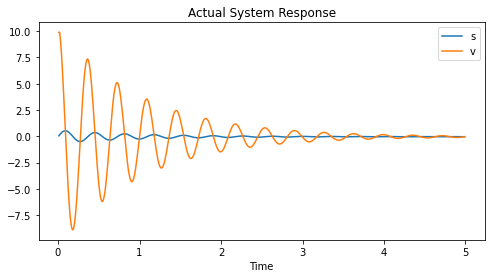

initial variable normalisation constants (division): [0.52766845 9.90299684]
variable normalisation constants (division): [0.52739613 9.92194783]


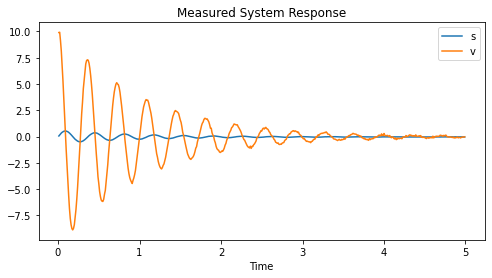

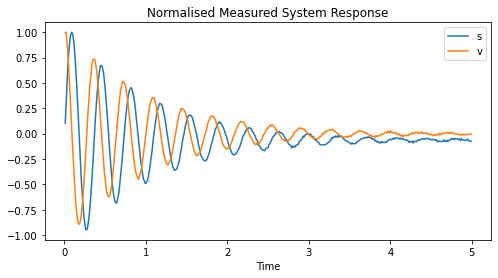

In [6]:
tstamps,Sol,_=exsys(5,k1=300,k2=0,dt=0.01)
dt=_[0]
sf=1/dt

Sol=Sol[:,int(1.1*0.01/dt):]
tstamps=tstamps[int(1.1*0.01/dt):]

#Sol[1]=np.gradient(Sol[0],dt)

#Sol[0]=np.random.normal(Sol[0],0.05*np.max(np.abs(Sol[0])))
#Sol[1]=np.random.normal(Sol[1],0.05*np.max(np.abs(Sol[1])))

plt.figure(figsize=(8, 4))
plt.title('Actual System Response')
plt.xlabel('Time')
plt.plot(tstamps,Sol[0,:],label='s')
plt.plot(tstamps,Sol[1,:],label='v')
#plt.xlim([0,12])
plt.legend()
plt.show()

#x, x' normalisation - noise free

midpoint=[0,0]
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2
#print(midpoint)
Solm=Sol-np.reshape(midpoint,(2,-1))

nc=np.abs(Solm.T).max(axis=0)
print('initial variable normalisation constants (division):',nc)
nSol=Solm.T/nc
nSol=nSol.T
nSolnf=np.copy(nSol)
nSolnfdt=np.gradient(nSolnf[:,:],dt,axis=1)

#noise addition
np.random.seed(0) #seed 
nSol=np.random.normal(nSol,0.005)
#nSol=nSol+np.random.uniform(low=-0.01,high=0.01,size=nSol.shape)

#implied noisy measurements - unnormalised
uSol=(nSol.T*nc).T+np.reshape(midpoint,(2,-1))
uSoldt=np.gradient(uSol[:,:],dt,axis=1)

#x, x' normalisation - with noise

midpoint=[0,0]
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2
uSolm=uSol-np.reshape(midpoint,(2,-1))

nc=np.abs(uSolm.T).max(axis=0)
print('variable normalisation constants (division):',nc)
nSol=uSolm.T/nc
nSol=nSol.T
nSoldt=np.gradient(nSol[:,:],dt,axis=1)

plt.figure(figsize=(8, 4))
plt.title('Measured System Response')
plt.xlabel('Time')
plt.plot(tstamps,uSol[0,:],label='s')
plt.plot(tstamps,uSol[1,:],label='v')
#plt.xlim([0,12])
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.title('Normalised Measured System Response')
plt.xlabel('Time')
plt.plot(tstamps,nSol[0,:],label='s')
plt.plot(tstamps,nSol[1,:],label='v')
#plt.xlim([0,12])
plt.legend()
plt.show()

In [7]:
deg=3

In [8]:
mc=SINDyCV_t(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,0.01,1e-16,1e-16,0,10,ptf=0.3,normalise='auto')
names=polypool_names(['x','y'],deg)
dispmymod(mc,['x\'','y\''],names)
corrl=np.nan_to_num(mc/mc)

C:\Users\rautj\Desktop\MIR 2022\24September\mostFinalCode\jns\sindy_functions.py:1120: RuntimeWarning: invalid value encountered in true_divide
  modelchange=np.any(np.nan_to_num(cterms/cterms)!=np.nan_to_num(nterms/nterms))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


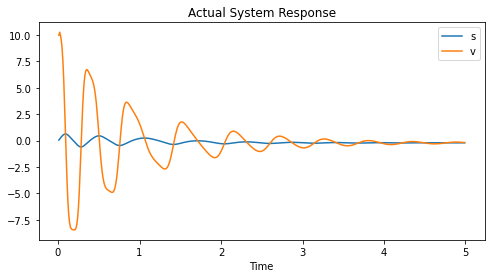

initial variable normalisation constants (division): [ 0.62621057 10.23865401]
variable normalisation constants (division): [ 0.62588738 10.25824733]


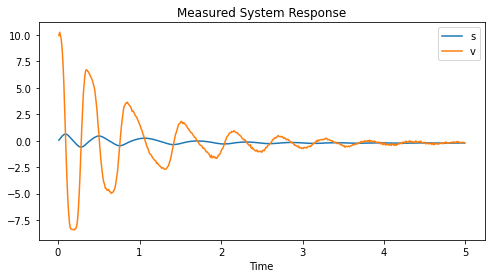

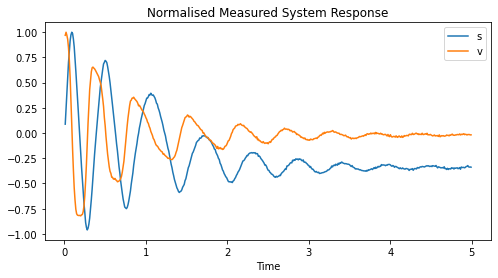

In [9]:
tstamps,Sol,_=exsys(5,k1=0,k2=1000,dt=0.01)
dt=_[0]
sf=1/dt

Sol=Sol[:,int(1.1*0.01/dt):]
tstamps=tstamps[int(1.1*0.01/dt):]

#Sol[1]=np.gradient(Sol[0],dt)

#Sol[0]=np.random.normal(Sol[0],0.05*np.max(np.abs(Sol[0])))
#Sol[1]=np.random.normal(Sol[1],0.05*np.max(np.abs(Sol[1])))

plt.figure(figsize=(8, 4))
plt.title('Actual System Response')
plt.xlabel('Time')
plt.plot(tstamps,Sol[0,:],label='s')
plt.plot(tstamps,Sol[1,:],label='v')
#plt.xlim([0,12])
plt.legend()
plt.show()

#x, x' normalisation - noise free

midpoint=[0,0]
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2
#print(midpoint)
Solm=Sol-np.reshape(midpoint,(2,-1))

nc=np.abs(Solm.T).max(axis=0)
print('initial variable normalisation constants (division):',nc)
nSol=Solm.T/nc
nSol=nSol.T
nSolnf=np.copy(nSol)
nSolnfdt=np.gradient(nSolnf[:,:],dt,axis=1)

#noise addition
np.random.seed(0) #seed 
nSol=np.random.normal(nSol,0.005)
#nSol=nSol+np.random.uniform(low=-0.01,high=0.01,size=nSol.shape)

#implied noisy measurements - unnormalised
uSol=(nSol.T*nc).T+np.reshape(midpoint,(2,-1))
uSoldt=np.gradient(uSol[:,:],dt,axis=1)

#x, x' normalisation - with noise

midpoint=[0,0]
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2
uSolm=uSol-np.reshape(midpoint,(2,-1))

nc=np.abs(uSolm.T).max(axis=0)
print('variable normalisation constants (division):',nc)
nSol=uSolm.T/nc
nSol=nSol.T
nSoldt=np.gradient(nSol[:,:],dt,axis=1)

plt.figure(figsize=(8, 4))
plt.title('Measured System Response')
plt.xlabel('Time')
plt.plot(tstamps,uSol[0,:],label='s')
plt.plot(tstamps,uSol[1,:],label='v')
#plt.xlim([0,12])
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.title('Normalised Measured System Response')
plt.xlabel('Time')
plt.plot(tstamps,nSol[0,:],label='s')
plt.plot(tstamps,nSol[1,:],label='v')
#plt.xlim([0,12])
plt.legend()
plt.show()

In [10]:
mc=SINDyCV_t(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,0.01,1e-16,1e-16,0,10,ptf=0.3,normalise='auto')
names=polypool_names(['x','y'],deg)
dispmymod(mc,['x\'','y\''],names)
corrnl=np.nan_to_num(mc/mc)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


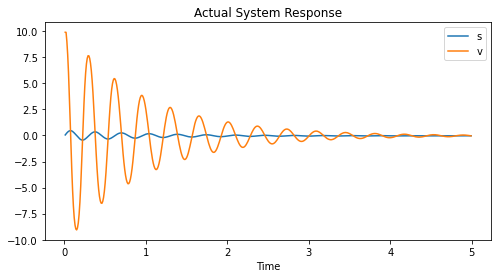

initial variable normalisation constants (division): [0.45904604 9.90043992]
variable normalisation constants (division): [0.45956947 9.88822309]


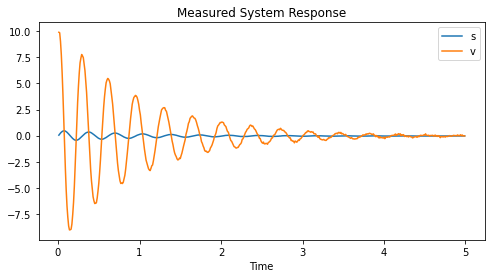

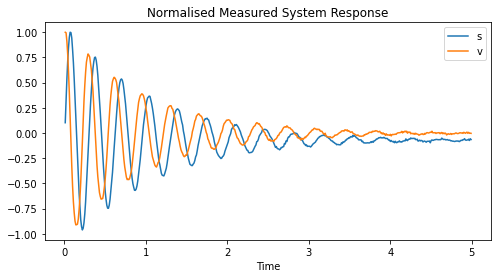

In [11]:
tstamps,Sol,_=exsys(5,k1=300,k2=1000,dt=0.01)
dt=_[0]
sf=1/dt

Sol=Sol[:,int(1.1*0.01/dt):]
tstamps=tstamps[int(1.1*0.01/dt):]

#Sol[1]=np.gradient(Sol[0],dt)

#Sol[0]=np.random.normal(Sol[0],0.05*np.max(np.abs(Sol[0])))
#Sol[1]=np.random.normal(Sol[1],0.05*np.max(np.abs(Sol[1])))

plt.figure(figsize=(8, 4))
plt.title('Actual System Response')
plt.xlabel('Time')
plt.plot(tstamps,Sol[0,:],label='s')
plt.plot(tstamps,Sol[1,:],label='v')
#plt.xlim([0,12])
plt.legend()
plt.show()

#x, x' normalisation - noise free

midpoint=[0,0]
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2
#print(midpoint)
Solm=Sol-np.reshape(midpoint,(2,-1))

nc=np.abs(Solm.T).max(axis=0)
print('initial variable normalisation constants (division):',nc)
nSol=Solm.T/nc
nSol=nSol.T
nSolnf=np.copy(nSol)
nSolnfdt=np.gradient(nSolnf[:,:],dt,axis=1)

#noise addition
#np.random.seed(0) #seed 
nSol=np.random.normal(nSol,0.005)
#nSol=nSol+np.random.uniform(low=-0.01,high=0.01,size=nSol.shape)

#implied noisy measurements - unnormalised
uSol=(nSol.T*nc).T+np.reshape(midpoint,(2,-1))
uSoldt=np.gradient(uSol[:,:],dt,axis=1)

#x, x' normalisation - with noise

midpoint=[0,0]
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2
uSolm=uSol-np.reshape(midpoint,(2,-1))

nc=np.abs(uSolm.T).max(axis=0)
print('variable normalisation constants (division):',nc)
nSol=uSolm.T/nc
nSol=nSol.T
nSoldt=np.gradient(nSol[:,:],dt,axis=1)

plt.figure(figsize=(8, 4))
plt.title('Measured System Response')
plt.xlabel('Time')
plt.plot(tstamps,uSol[0,:],label='s')
plt.plot(tstamps,uSol[1,:],label='v')
#plt.xlim([0,12])
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.title('Normalised Measured System Response')
plt.xlabel('Time')
plt.plot(tstamps,nSol[0,:],label='s')
plt.plot(tstamps,nSol[1,:],label='v')
#plt.xlim([0,12])
plt.legend()
plt.show()

In [12]:
mc,icv=SINDyCV_t(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,0.01,1e-16,1e-16,0,10,ptf=0.3,normalise='auto',reticv=True)
names=polypool_names(['x','y'],deg)
dispmymod(mc,['x\'','y\''],names)
corrlnl=np.nan_to_num(mc/mc)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [13]:
k1s=np.linspace(300,0,100)
k2s=np.linspace(0,1000,100)

LSRATE=[]
NLSRATE=[]
LNLSRATE=[]
LICVS=[]
NLICVS=[]

for ik in tnrange(len(k1s)):
    tstamps,Sol,_=exsys(5,k1=k1s[ik],k2=k2s[ik],dt=0.01)
    dt=_[0]

    Sol=Sol[:,int(1.1*0.01/dt):]
    tstamps=tstamps[int(1.1*0.01/dt):]
    
    lsrate=0
    nlsrate=0
    lnlsrate=0
    licvs=[]
    nlicvs=[]
    
    for a in tnrange(1000,leave=False):
        
        #x, x' normalisation - noise free

        midpoint=[0,0]
        #midpoint=np.average(Sol,axis=1)
        #midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2
        #print(midpoint)
        Solm=Sol-np.reshape(midpoint,(2,-1))

        nc=np.abs(Solm.T).max(axis=0)
        #print('initial variable normalisation constants (division):',nc)
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf[:,:],dt,axis=1)

        #noise addition
        #np.random.seed(0) #seed 
        nSol=np.random.normal(nSol,0.005)
        #nSol=nSol+np.random.uniform(low=-0.01,high=0.01,size=nSol.shape)

        #implied noisy measurements - unnormalised
        uSol=(nSol.T*nc).T+np.reshape(midpoint,(2,-1))
        uSoldt=np.gradient(uSol[:,:],dt,axis=1)

        #x, x' normalisation - with noise

        midpoint=[0,0]
        #midpoint=np.average(Sol,axis=1)
        #midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2
        uSolm=uSol-np.reshape(midpoint,(2,-1))

        nc=np.abs(uSolm.T).max(axis=0)
        #print('variable normalisation constants (division):',nc)
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol[:,:],dt,axis=1)
        
        mc,icv=SINDyCV_t(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,0.01,1e-16,1e-16,0,10,ptf=0.3,normalise='auto',reticv=True)
        licvs.append(icv[1,1])
        nlicvs.append(icv[6,1])
        
        if np.all(np.nan_to_num(mc/mc)==corrl):
            lsrate+=1
        elif np.all(np.nan_to_num(mc/mc)==corrnl):
            nlsrate+=1
        elif np.all(np.nan_to_num(mc/mc)==corrlnl):
            lnlsrate+=1
    
    LSRATE.append(lsrate)
    NLSRATE.append(nlsrate)
    LNLSRATE.append(lnlsrate)
    
    LICVS.append(licvs)
    NLICVS.append(nlicvs)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide
C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

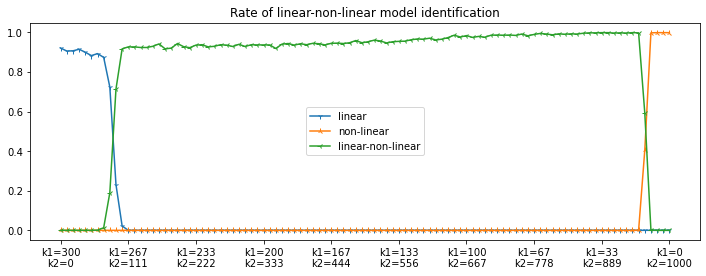

In [14]:
plt.figure(figsize=(12, 4))
plt.title('Rate of linear-non-linear model identification')
plt.plot(np.array(LSRATE)/1000,'1-',label='linear')
plt.plot(np.array(NLSRATE)/1000,'2-',label='non-linear')
plt.plot(np.array(LNLSRATE)/1000,'3-',label='linear-non-linear')
plt.xticks(np.arange(110)[::11],['k1=300\nk2=0','k1=267\nk2=111','k1=233\nk2=222','k1=200\nk2=333','k1=167\nk2=444','k1=133\nk2=556','k1=100\nk2=667','k1=67\nk2=778','k1=33\nk2=889','k1=0\nk2=1000'])
plt.legend()
plt.show()

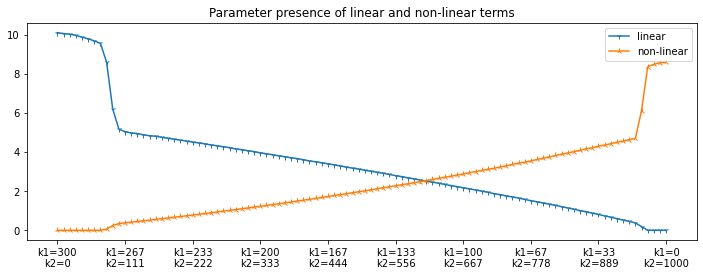

In [15]:
plt.figure(figsize=(12, 4))
plt.title('Parameter presence of linear and non-linear terms')
plt.plot(np.abs(np.average(LICVS,axis=1)),'1-',label='linear')
plt.plot(np.abs(np.average(NLICVS,axis=1)),'2-',label='non-linear')
plt.legend()
plt.xticks(np.arange(110)[::11],['k1=300\nk2=0','k1=267\nk2=111','k1=233\nk2=222','k1=200\nk2=333','k1=167\nk2=444','k1=133\nk2=556','k1=100\nk2=667','k1=67\nk2=778','k1=33\nk2=889','k1=0\nk2=1000'])
plt.show()

In [16]:
np.vstack((np.array(LSRATE)/1000,np.array(NLSRATE)/1000,np.array(LNLSRATE)/1000))

array([[0.921, 0.906, 0.907, 0.915, 0.9  , 0.883, 0.893, 0.874, 0.724, 0.231, 0.022, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0. 

In [17]:
np.vstack((np.abs(np.average(LICVS,axis=1)),np.abs(np.average(NLICVS,axis=1))))

array([[1.00970300e+01, 1.00508280e+01, 1.00161663e+01, 9.95895763e+00, 9.86454142e+00, 9.78593348e+00, 9.67296514e+00, 9.54938651e+00, 8.59111084e+00, 6.19314059e+00, 5.16687244e+00, 5.03629402e+00, 4.97534679e+00, 4.94530236e+00, 4.87755233e+00, 4.83059789e+00, 4.80517660e+00, 4.74791887e+00, 4.69844943e+00, 4.65269269e+00, 4.60483077e+00, 4.55652688e+00, 4.50339875e+00, 4.46599537e+00, 4.41495309e+00, 4.35842638e+00, 4.31897096e+00, 4.26968894e+00, 4.22229690e+00, 4.15574465e+00, 4.11992644e+00, 4.06506180e+00, 4.01965909e+00, 3.95736128e+00, 3.90961615e+00, 3.85992379e+00, 3.80586669e+00, 3.75748385e+00, 3.70667138e+00, 3.66217497e+00, 3.60332774e+00, 3.54512732e+00, 3.49979899e+00, 3.44826829e+00, 3.39858418e+00, 3.34503658e+00, 3.28832553e+00, 3.22689596e+00, 3.17587522e+00, 3.12669531e+00, 3.06511036e+00, 3.01586154e+00, 2.96135846e+00, 2.91479114e+00, 2.85110614e+00, 2.79357418e+00, 2.74349204e+00, 2.68081207e+00, 2.62780093e+00, 2.56892453e+00, 2.51523084e+00, 2.45798663e+00, 

In [18]:
#np.savetxt('mtyperate.bt',np.vstack((np.array(LSRATE)/1000,np.array(NLSRATE)/1000,np.array(LNLSRATE)/1000)))
#np.savetxt('pp.bt',np.vstack((np.abs(np.average(LICVS,axis=1)),np.abs(np.average(NLICVS,axis=1)))))

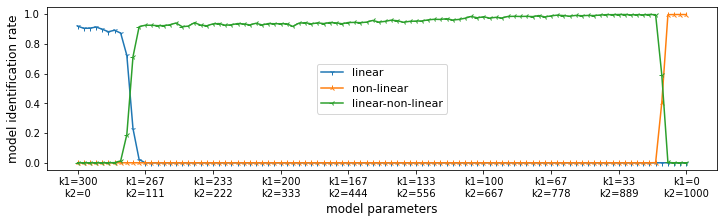

In [19]:
plt.figure(figsize=(12, 3))
#plt.title('Rate of linear-non-linear model identification')
plt.ylabel('model identification rate',fontsize=12)
plt.xlabel('model parameters',fontsize=12)
plt.plot(np.loadtxt('mtyperate.bt')[0],'1-',label='linear')
plt.plot(np.loadtxt('mtyperate.bt')[1],'2-',label='non-linear')
plt.plot(np.loadtxt('mtyperate.bt')[2],'3-',label='linear-non-linear')
plt.xticks(np.arange(110)[::11],['k1=300\nk2=0','k1=267\nk2=111','k1=233\nk2=222','k1=200\nk2=333','k1=167\nk2=444','k1=133\nk2=556','k1=100\nk2=667','k1=67\nk2=778','k1=33\nk2=889','k1=0\nk2=1000'])
plt.legend(fontsize=11)
plt.show()

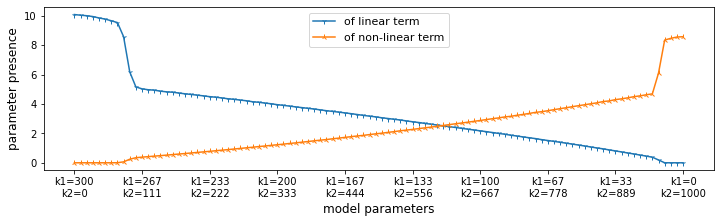

In [20]:
plt.figure(figsize=(12, 3))
#plt.title('Parameter presence of linear and non-linear terms')
plt.ylabel('parameter presence',fontsize=12)
plt.xlabel('model parameters',fontsize=12)
plt.plot(np.loadtxt('pp.bt')[0],'1-',label='of linear term')
plt.plot(np.loadtxt('pp.bt')[1],'2-',label='of non-linear term')
plt.legend(fontsize=11)
plt.xticks(np.arange(110)[::11],['k1=300\nk2=0','k1=267\nk2=111','k1=233\nk2=222','k1=200\nk2=333','k1=167\nk2=444','k1=133\nk2=556','k1=100\nk2=667','k1=67\nk2=778','k1=33\nk2=889','k1=0\nk2=1000'])
plt.show()